In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import KNNImputer

#altri import futuri

## Caricamento e analisi del dataset

In [290]:
dataset = pd.read_csv("dataset/secondary_data.csv", sep=";")
print("Dimension:", dataset.shape)
dataset.head()

Dimension: (61069, 21)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [291]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

### Distribuzione delle features
Siamo interessati a classificare i funghi come velenosi o meno, per questo motivo identifichiamo le due classi di interesse a partire dalla colonna "class" del dataset.

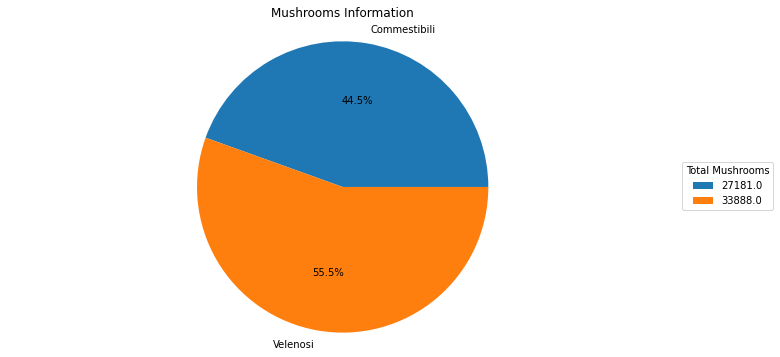

In [259]:
classes = [{"Commestibili": (dataset["class"] == "e").sum(), "Velenosi": (dataset["class"] == "p").sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Commestibili"])
total_p = float(total["Velenosi"])
mushrooms = [total_e, total_p]
mushrooms_labels = 'Commestibili','Velenosi'
fig, ax = plt.subplots(figsize = (12,6))
plt.pie(mushrooms,labels=mushrooms_labels,autopct='%1.1f%%')
plt.title('Mushrooms Information')
plt.axis('equal')
plt.legend(mushrooms,title="Total Mushrooms",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
fig.set_facecolor('white')
plt.show()

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

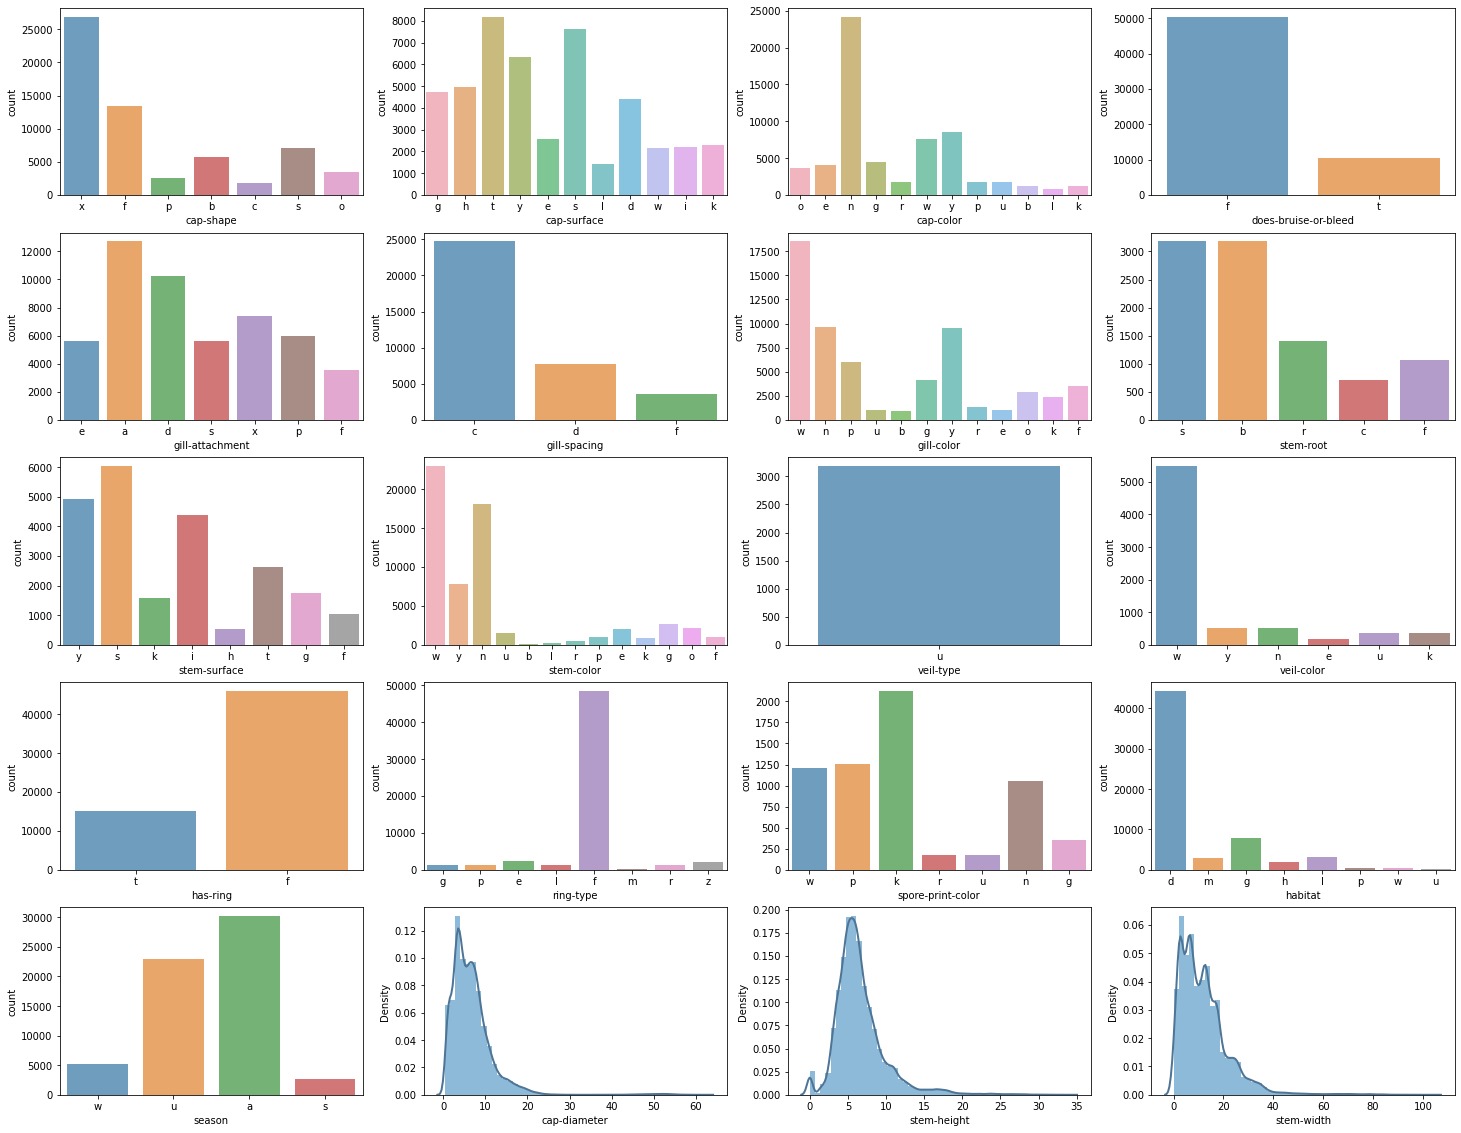

In [260]:
categorical = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 
'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
continous = ['cap-diameter', 'stem-height', 'stem-width']

fig = plt.figure(figsize=(25,20))
for i in range(0, len(categorical)) :
    fig.add_subplot(5,4,i+1)
    sns.countplot(x=categorical[i], data=dataset, alpha=.7)

for col in continous:
    fig.add_subplot(5,4,i+2)
    i+=1
    sns.distplot(dataset[col].dropna(), kde_kws={"lw": 2, "color": 'xkcd:cadet blue'}, hist_kws={"alpha": .5})

## Rimozione di features con dati nulli
Si rimuovono le features con varianza nulla presenti nel dataset, ovvero quelle features il cui valore è costante, nel nostro caso solamente la variabile "veil-type" come visibile graficamente.

In [292]:
dataset = dataset.drop("veil-type", 1)
dataset.isnull().sum()

/tmp/ipykernel_6741/3082125834.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset = dataset.drop("veil-type", 1)


class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64


Si procede con la trasformazione dei valori categorici in numerici e si salva il dizionario che mantiene il mapping per un eventuale utilizzo futuro.

In [293]:
class LabelEncoderByCol(BaseEstimator, TransformerMixin):
    def __init__(self,col):
        #List of column names in the DataFrame that should be encoded
        self.col = col
        #List storing a LabelEncoder for each column
        self.encoders = {}
        #List storing the mapping for each column
        self.mapping = []
        for el in self.col:
            self.encoders[el] = LabelEncoder()
            
    def fit(self,x,y=None):
        #Fill missing values with the string 'NaN'
        x[self.col] = x[self.col].fillna('NaN')
        for el in self.col:
            #Only use the values that are not 'NaN' to fit the Encoder
            a = x[el][x[el]!='NaN']
            self.encoders[el].fit(a)
        return self

    def transform(self,x,y=None):
        #Fill missing values with the string 'NaN'
        x[self.col] = x[self.col].fillna('NaN')
        for el in self.col:
            if (x[el].dtype == "object") :
                #Only use the values that are not 'NaN' to fit the Encoder
                a = x[el][x[el]!='NaN']
                #Store an ndarray of the current column
                b = x[el].to_numpy()
                #Replace the elements in the ndarray that are not 'NaN'
                #using the transformer
                b[b!='NaN'] = self.encoders[el].transform(a)
                #Overwrite the column in the DataFrame
                x[el]=b
                mapping_dict = {index : label for index , label in enumerate(self.encoders[el].classes_)}
                self.mapping.append(mapping_dict)
        #return the transformed DataFrame
        return x

In [294]:
encoder = LabelEncoderByCol(dataset.columns)
encoder.fit(dataset)
mapped_dataset = encoder.transform(dataset)

#encoder.mapping

Completiamo trasformando il tipo di dato associato alle features categoriche da 'object' in 'Int64', oggetto che accetta valori interi nulli.

In [295]:
for el in mapped_dataset.columns:
    if (mapped_dataset[el].dtype == "object"):
        mapped_dataset[el] = np.floor(pd.to_numeric(mapped_dataset[el], errors='coerce')).astype('Int64')
mapped_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  Int64  
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  Int64  
 3   cap-surface           46949 non-null  Int64  
 4   cap-color             61069 non-null  Int64  
 5   does-bruise-or-bleed  61069 non-null  Int64  
 6   gill-attachment       51185 non-null  Int64  
 7   gill-spacing          36006 non-null  Int64  
 8   gill-color            61069 non-null  Int64  
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   Int64  
 12  stem-surface          22945 non-null  Int64  
 13  stem-color            61069 non-null  Int64  
 14  veil-color            7413 non-null   Int64  
 15  has-ring           

In [296]:
mapped_dataset.isnull().sum()

class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64

### Imputazione delle features con valori nulli
Si utilizza un meccanismo di imputazione per sopperire alla presenza di dati mancanti per le features da scartare per la politica scelta (nan > 20%), ma che presentano una buona correlazione con la variabile target e una buona distribuzione dei valori.
Ovviamente il meccanismo è applicato anche a quelle features con meno del 20% di valori nulli, così da ripristinare la variabile per l'uso nella classificazione rimpiazzando tutti i dati mancanti.

IMPUTAZIONE PER: cap-surface,14120 | gill-attachment,9884 | gill-spacing,25063 | stem-surface,38124 | ring-type,2471

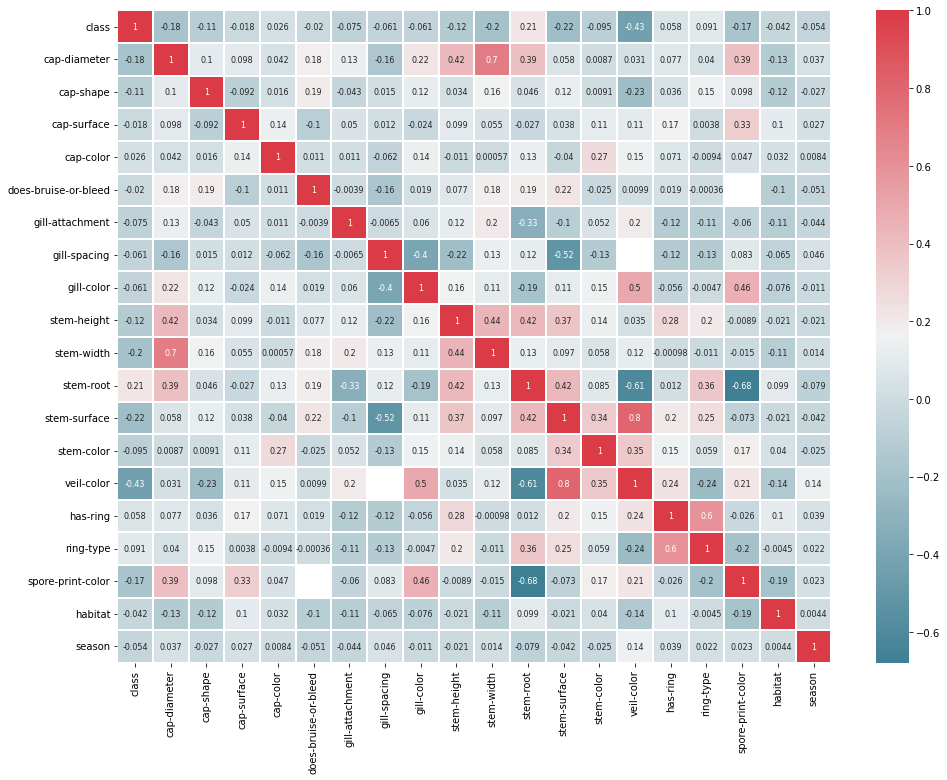

In [297]:
plt.figure(figsize=(16,12))

sns.heatmap(mapped_dataset.corr(), linewidths=.1, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, annot_kws={"size": 8})

plt.yticks(rotation=0);
#plt.savefig("corr.png", format='png', dpi=400, bbox_inches='tight')

In [298]:
imp = KNNImputer(n_neighbors=1, weights="uniform")
imp_dataset = pd.DataFrame(imp.fit_transform(mapped_dataset), columns = mapped_dataset.columns)

In [287]:
imp_dataset.isnull().sum()

class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-surface            0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

Nuova correlazione dopo imputazione.

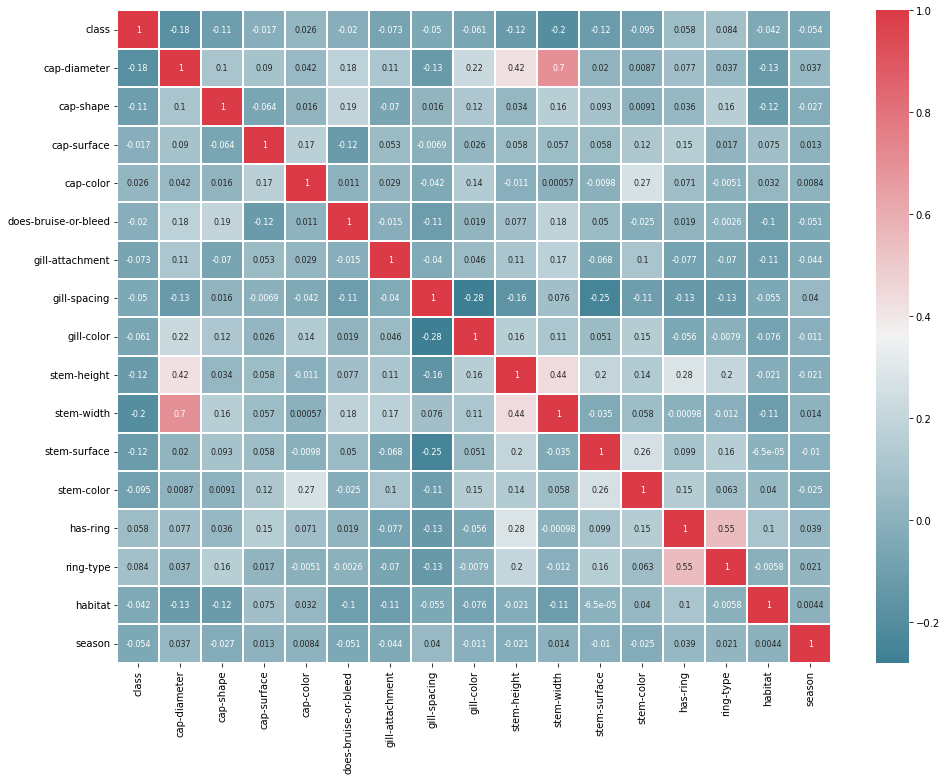

In [288]:
plt.figure(figsize=(16,12))

sns.heatmap(imp_dataset.corr(), linewidths=.1, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, annot_kws={"size": 8})

plt.yticks(rotation=0);
#plt.savefig("corr.png", format='png', dpi=400, bbox_inches='tight')